> Extracting images from video
done
(480, 720, 3)


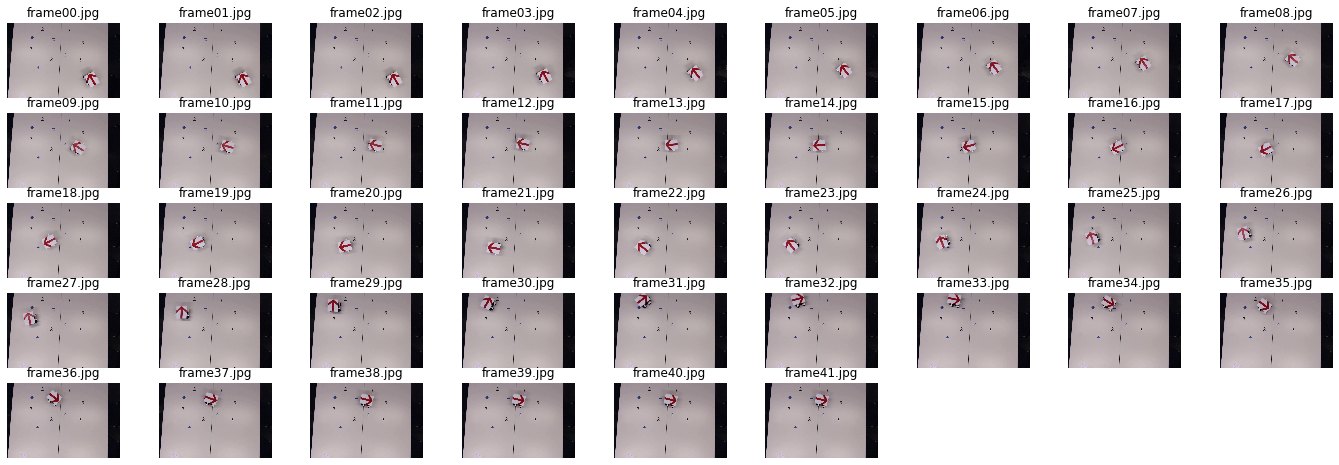

In [1]:
%matplotlib inline
from helpers import extract_images, load_data
import matplotlib.pyplot as plt
import numpy as np

# extract images from video
extract_images(data_path='./data/robot_parcours_1.avi')

# load data from extracted images
images, images_names = load_data()

# plot images
fig, axes = plt.subplots(5, int(len(images)/5)+1, figsize=(24, 8))
for ax, im, nm in zip(axes.ravel(), images, images_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)   
for ax in axes.ravel()[len(images):]:
    fig.delaxes(ax)
    
print(images[0].shape)

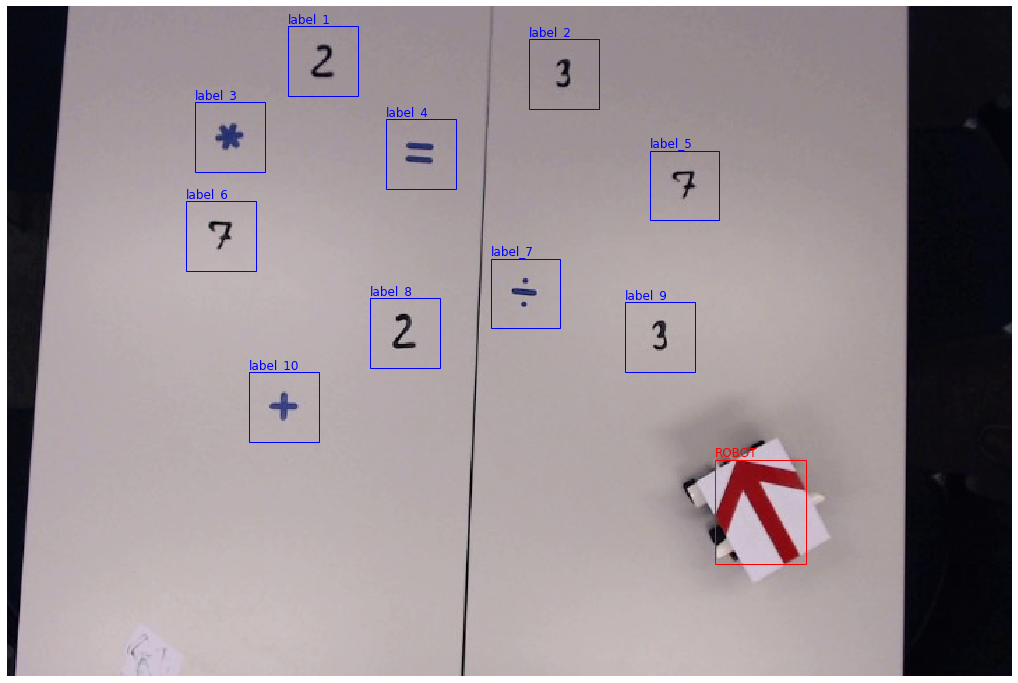

In [2]:
from helpers import get_arrow_bb, segmentation, get_object_bb
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(18, 14))
ax.imshow(images[0])

# Robot bb
arrow_bb = get_arrow_bb(images[0])
minr_a, minc_a, maxr_a, maxc_a = arrow_bb
x, y = minc_a+(maxc_a-minc_a)/2, minr_a+(maxr_a-minr_a)/2
rect = mpatches.Rectangle((minc_a, minr_a), maxc_a - minc_a, maxr_a - minr_a, fill=False, edgecolor='red', linewidth=1)
ax.add_patch(rect)
ax.annotate('ROBOT', (x-(maxc_a - minc_a)/2, y-3-(maxr_a - minr_a)/2), color='r', fontsize=12)

# Object bb
segmented = segmentation(images[0], arrow_bb)
boxes = get_object_bb(segmented)

for box in boxes:
    minr, minc, maxr, maxc = boxes[box]
    x, y = minc+(maxc-minc)/2, minr+(maxr-minr)/2
    rect = mpatches.Rectangle((x-25, y-25), 50, 50, fill=False, edgecolor='blue', linewidth=1)
    ax.add_patch(rect)
    ax.annotate(box, (x-25, y-28), color='b', fontsize=12)

ax.set_axis_off()

In [16]:
from helpers import Overlap, crop_image
positions = []
operation_order = []
cropped_object = []

for ind, im in enumerate(images): 
    if ind == 0: 
        arrow_bb = get_arrow_bb(images[0])
        segmented = segmentation(images[0], arrow_bb)
        boxes = get_object_bb(segmented)
    
    fig, ax = plt.subplots()
    ax.imshow(im)
    ax.axis('off') 
    
    minr_a, minc_a, maxr_a, maxc_a = get_arrow_bb(im)
    x_robot, y_robot = minc_a+(maxc_a-minc_a)/2, minr_a+(maxr_a-minr_a)/2
    rect = mpatches.Rectangle((minc_a, minr_a), maxc_a - minc_a, maxr_a - minr_a, fill=False, edgecolor='red', linewidth=0.5)
    ax.add_patch(rect)
    ax.annotate('ROBOT', (x_robot-(maxc_a - minc_a)/2, y_robot-3-(maxr_a - minr_a)/2), color='r', fontsize=4)
    
    for box in boxes:
        minr, minc, maxr, maxc = boxes[box]
        x, y = minc+(maxc-minc)/2, minr+(maxr-minr)/2
        rect = mpatches.Rectangle((x-25, y-25), 50, 50, fill=False, edgecolor='blue', linewidth=0.5)
        ax.add_patch(rect)
        ax.annotate(box, (x-25, y-28), color='b', fontsize=4)
        
        if Overlap([minc_a, minr_a], [maxc_a, maxr_a], [x-25, y-25], [x+25, y+25]):
            if box not in operation_order:
                cropped_object.append(crop_image(images[0], [int(x-25), int(y-25), int(x+25), int(y+25)]))
                operation_order.append(box)
            
    if len(positions) > 1:
        for last, pos in zip(positions,positions[1:]):
            point = mpatches.Circle(pos, 2, color='r')
            con = mpatches.ConnectionPatch(last,pos, 'data', color='k', linewidth=0.5)
            ax.add_patch(point)
            ax.add_patch(con)
    
    string = ''
    if operation_order:
        for op in operation_order:
            string += str(op)+', '
    
    ax.annotate(string, (50, 400), color='g', fontsize=8)
    
    
    if ind > 0:
        positions.append((x_robot, y_robot))

    if ind < 10:
        plt.savefig('./tmp/red_arrow_0'+str(ind)+'.jpg', bbox_inches='tight', pad_inches=0, dpi=300)
    else: 
        plt.savefig('./tmp/red_arrow_'+str(ind)+'.jpg', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

In [17]:
print(operation_order)

['label_9', 'label_7', 'label_8', 'label_10', 'label_6', 'label_3', 'label_1', 'label_4']


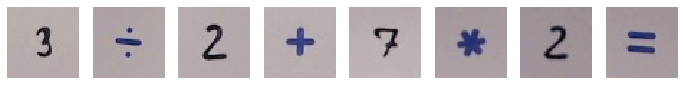

In [27]:
fig, axes = plt.subplots(1, len(cropped_object), figsize=(12,4))
ax = axes.ravel()
for ind, crop in enumerate(cropped_object): 
    ax[ind].imshow(crop)
    ax[ind].axis('off')

In [ ]:
import cv2
import numpy as np
import os

def frames_to_video(inputpath, outputpath, fps):
    image_array = []
    files = [nm for nm in os.listdir(inputpath) if '.jpg' in nm]  # make sure to only load .jpg
    files.sort()
    for i in range(len(files)):
        img = cv2.imread(inputpath + files[i])
        size =  (img.shape[1],img.shape[0])
        img = cv2.resize(img,size)
        image_array.append(img)
    fourcc = cv2.VideoWriter_fourcc('D', 'I', 'V', 'X')
    out = cv2.VideoWriter(outputpath,fourcc, fps, size)
    for i in range(len(image_array)):
        out.write(image_array[i])
    out.release()


inputpath = './tmp/'
outpath =  './tmp/video.mp4'
fps = 4
frames_to_video(inputpath,outpath,fps)